<a href="https://colab.research.google.com/github/javohiryoldashovBigData/Binary_Classification_with_a_Bank_Churn_Dataset/blob/main/Binary_Classification_with_a_Bank_Churn_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
sns.set_style('whitegrid')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [ ]:
train.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [ ]:
train.describe().style.background_gradient('Blues')

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.500000,15692005.019026,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.356500,71397.816791,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.250000,15633141.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.500000,15690169.000000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.750000,15756824.000000,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [ ]:
def describe_(df):
    dict_=pd.DataFrame()
    dict_['null_values']=df.isna().sum()
    dict_['unique_']=df.nunique().values  #no of unique values/categories for each feature

    return dict_
describe_(train).style.background_gradient(cmap='Blues')

,null_values,unique_
id,0,165034
CustomerId,0,23221
Surname,0,2797
CreditScore,0,457
Geography,0,3
Gender,0,2
Age,0,71
Tenure,0,11
Balance,0,30075
NumOfProducts,0,4


In [ ]:
def describe_(df):
    dict_=pd.DataFrame()
    dict_['null_values']=df.isna().sum()
    dict_['unique_']=df.nunique().values  #no of unique values/categories for each feature

    return dict_
describe_(test).style.background_gradient(cmap='Blues')

,null_values,unique_
id,0,110023
CustomerId,0,19698
Surname,0,2708
CreditScore,0,454
Geography,0,3
Gender,0,2
Age,0,74
Tenure,0,11
Balance,0,22513
NumOfProducts,0,4


In [ ]:
train.drop(['id','CustomerId'],axis=1,inplace=True)

<Axes: xlabel='Exited', ylabel='count'>

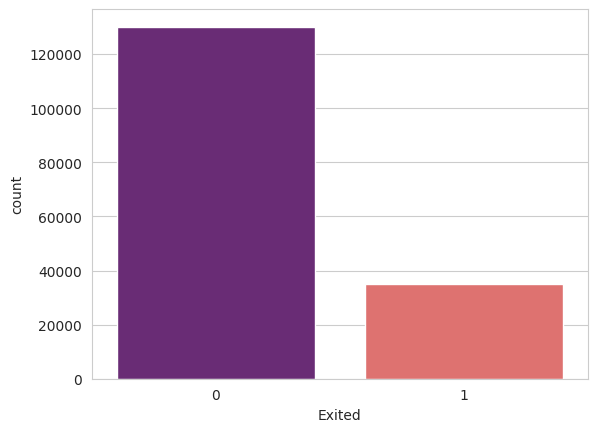

In [ ]:
sns.countplot(x='Exited',data=train,palette='magma')

<Axes: xlabel='Geography', ylabel='count'>

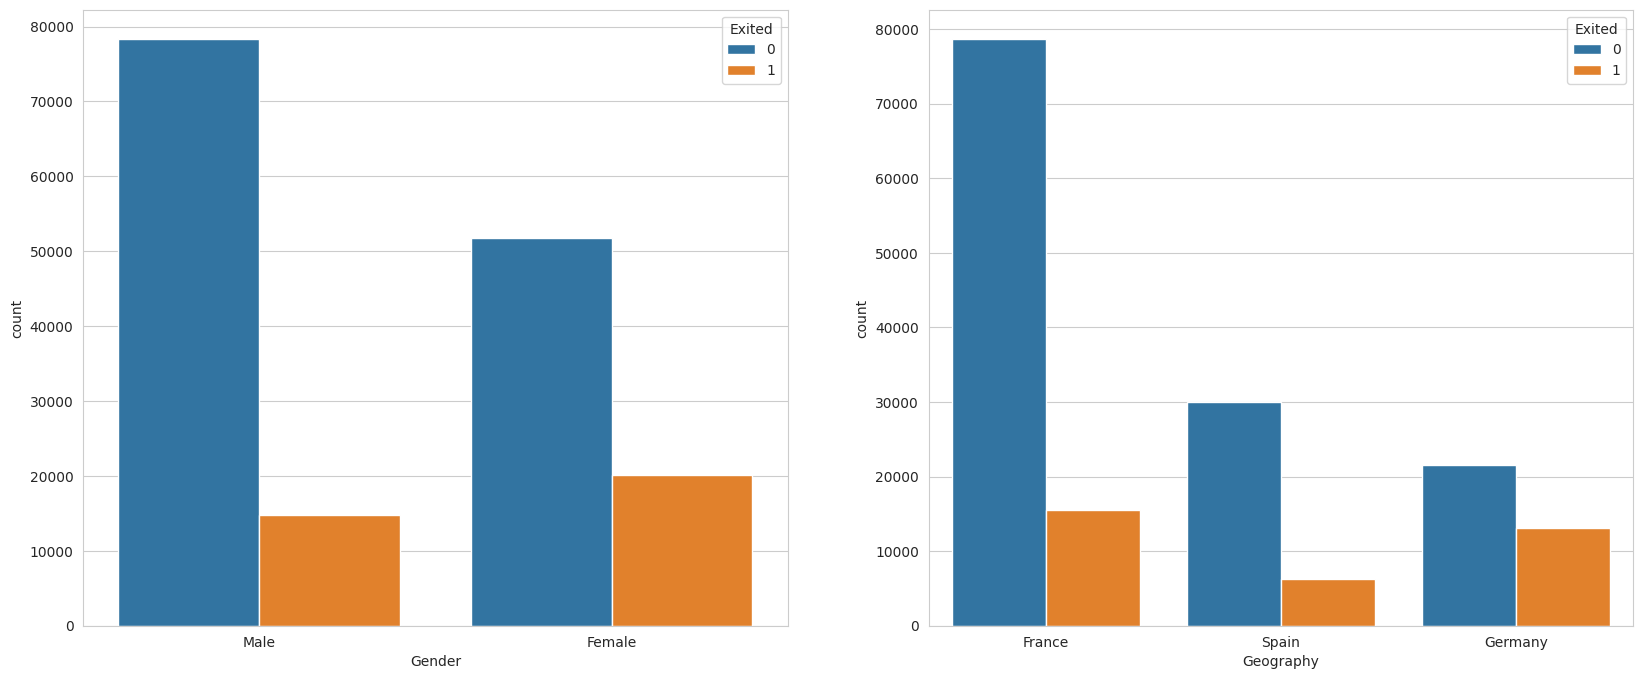

In [ ]:
fig=plt.figure(figsize=(20,8))
ax=[None]*2
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))
sns.countplot(x='Gender',data=train,ax=ax[0],hue='Exited')
sns.countplot(x='Geography',data=train,ax=ax[1],hue='Exited')

In [ ]:
numerical_features=[feature for feature in train.columns if train[feature].dtype!='object']

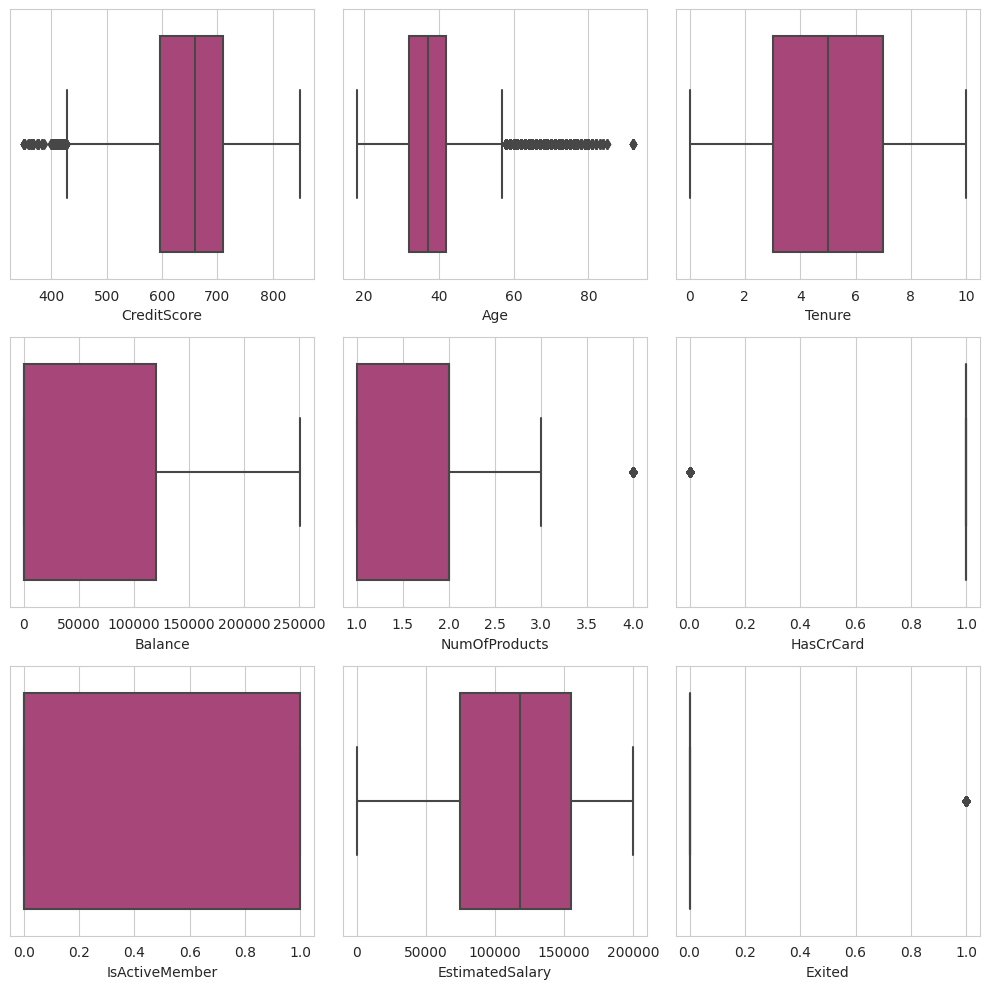

In [ ]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(10,10))
i=0
for feature in numerical_features:
    n=i//3
    m=i%3
    sns.boxplot(x=feature,data=train,ax=ax[n,m],palette='magma')
    i+=1
    plt.tight_layout()

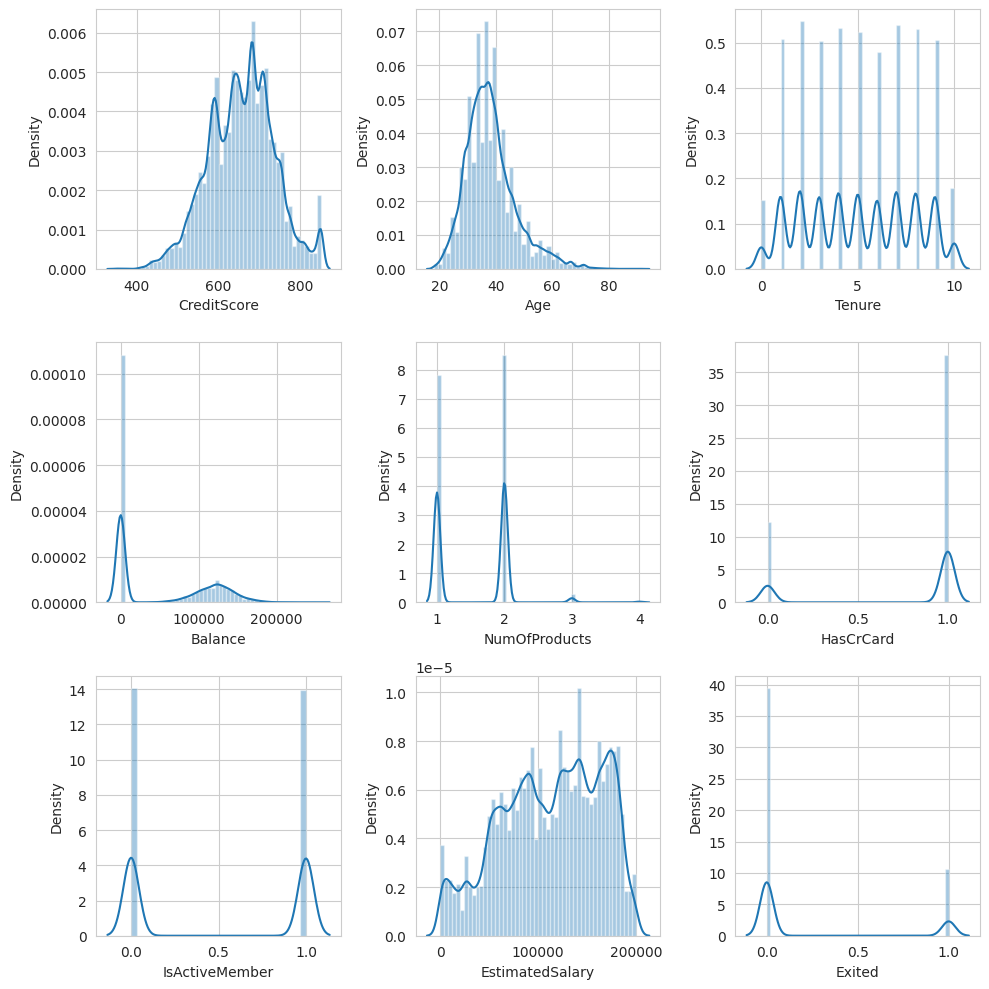

In [ ]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(10,10))
i=0
for feature in numerical_features:
    n=i//3
    m=i%3
    sns.distplot(train[feature],ax=ax[n,m])
    i+=1
    plt.tight_layout()

<Axes: >

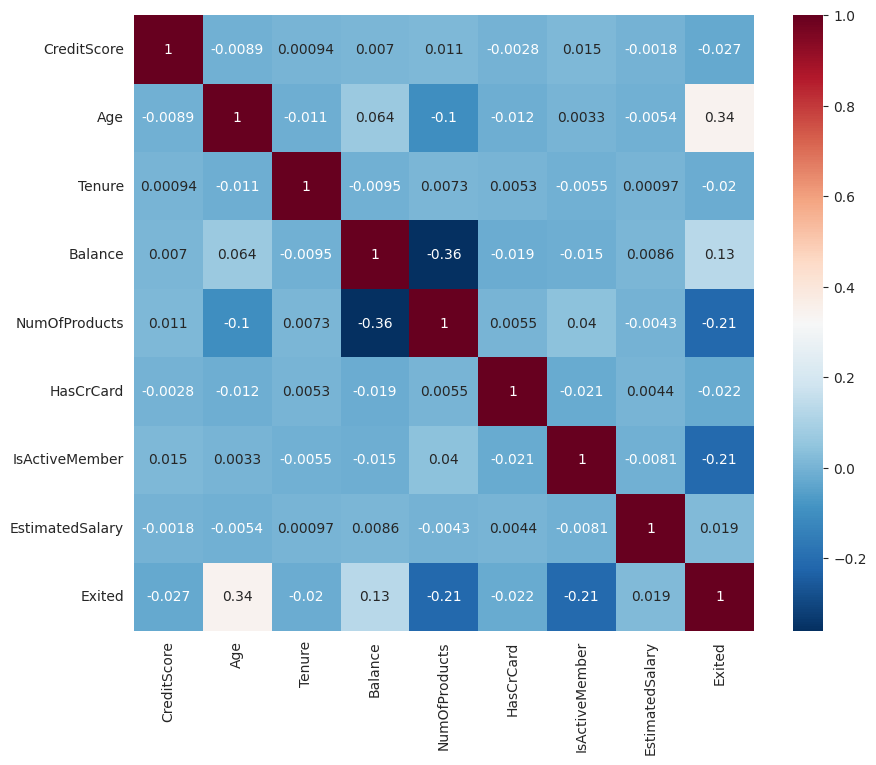

In [ ]:
plt.figure(figsize=(10,8))
corr=train[numerical_features].corr()
sns.heatmap(corr,cmap=plt.cm.RdBu_r,annot=True,annot_kws={'size':10})

In [ ]:
train.drop('Surname',axis=1,inplace=True)

In [ ]:
categorical_features=[feature for feature in train.columns if train[feature].dtype=='object']

In [ ]:
df_num=train[numerical_features]
df_cat=train[categorical_features]

In [ ]:
ohe=OneHotEncoder()
df_cat=pd.DataFrame(ohe.fit_transform(df_cat).toarray())
df_cat.columns=df_cat.columns.astype(str)

In [ ]:
df_=pd.concat([df_num,df_cat],axis=1)

In [ ]:
X=df_.drop('Exited',axis=1)
y=df_['Exited']

In [ ]:
forest=RandomForestClassifier()
param_grid = {
    'n_estimators': [100,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search=RandomizedSearchCV(estimator=forest,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

In [ ]:
grid_search.fit(X,y)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 500]},
                   scoring='roc_auc', verbose=True)

In [ ]:
forest=grid_search.best_estimator_
scores_forest=cross_val_score(forest,X,y,cv=5,scoring='roc_auc')
print('Mean value of roc_auc_score for RF Classifier:{}'.format(np.mean(scores_forest)))

Mean value of roc_auc_score for RF Classifier:0.8851591028027082


In [ ]:
#xgb classifier
xgb=XGBClassifier()
param_grid={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid_search=RandomizedSearchCV(estimator=xgb,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

In [ ]:
grid_search.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc', verbose=True)

In [ ]:
xgb=grid_search.best_estimator_
scores_xgb=cross_val_score(xgb,X,y,cv=5,scoring='roc_auc')
print('Mean value of roc_auc_score for XGB Classifier:{}'.format(np.mean(scores_xgb)))

Mean value of roc_auc_score for XGB Classifier:0.889323985382261


In [ ]:
#lgbm
lgbm=LGBMClassifier(objective = 'binary',
                     n_estimators = 500,
                     max_depth = 7,
                     learning_rate = 0.01,
                     num_leaves = 20,
                     reg_alpha = 3,
                     reg_lambda = 3,
                     subsample = 0.7,
                     colsample_bytree = 0.7)
lgbm_scores=cross_val_score(lgbm,X,y,cv=3,scoring='roc_auc')
np.mean(lgbm_scores)

[LightGBM] [Info] Number of positive: 23280, number of negative: 86742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 110022, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211594 -> initscore=-1.315344
[LightGBM] [Info] Start training from score -1.315344
[LightGBM] [Info] Number of positive: 23281, number of negative: 86742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 110023, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315301
[L

0.8887887011541346

In [ ]:
gbt=GradientBoostingClassifier()
gbt_scores=cross_val_score(gbt,X,y,cv=3,scoring='roc_auc')
np.mean(gbt_scores)

0.8883152530105599

In [ ]:
#voting classifier
voting_clf = VotingClassifier(
 estimators=[('xgb', xgb), ('rf', forest),('lgbm',lgbm),('gbt',gbt)],
 voting='soft'
 )
scores_voting=cross_val_score(voting_clf,X,y,cv=5,scoring='roc_auc')
print('Mean value of roc_auc_score for Voting classifier:{}'.format(np.mean(scores_voting)))

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304


In [ ]:
voting_clf.fit(X,y)

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=1.5,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=8)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.7,
                                             learning_rate=0.01, max_depth=7,
                                             n_estimators=500, num_leaves=20,
                                             objective='binary', reg_alpha=3,
                                             reg_lambda=3, subsample=0.7)),
                             ('gbt', GradientBoostingClassifier())],
                 voting='soft')

Submission
#that is enough for today


In [ ]:
test.head(2)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.0,1,1.0,0.0,72549.27


In [ ]:
#preprocessing test data
test_=test.copy()
test_.drop(['id','CustomerId','Surname'],axis=1,inplace=True)
numerical_features.remove('Exited')
df_num=test_[numerical_features]
df_cat=test_[categorical_features]

In [ ]:
df_cat=pd.DataFrame(ohe.transform(df_cat).toarray())
df_cat.columns=df_cat.columns.astype(str)
df_=pd.concat([df_num,df_cat],axis=1)

In [ ]:
y_pred=voting_clf.predict_proba(df_)

In [ ]:
y_pred[:,1]

In [ ]:
test['defects']=y_pred[:,1]

In [ ]:
sub_=test[['id','defects']]
sub_.to_csv('submission_.csv',index=False)